<a href="https://colab.research.google.com/github/LongNguyen1984/TimeSeriesWithPython/blob/main/TwoVariablePPGGlucoseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
**This use a 2-varible model to predict gluocse**
Y = $\alpha_1$*$X_1$ + $\alpha_2$*$X_2$ + $\beta$

Where: 
  * $X_1$: DC level of PPG
  * $X_2$: Pulse Transition Time (PTT) of PPG


##Import and Load PPG data

The PPG data has 4 channels with a sampling rate 70
 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

import pandas as pd
ppg  = pd.read_csv('drive/MyDrive/Dataset/long2aprilgLab1.csv', header=0)
# print out 20 first row of PPG
ppg.head(20)

,850nm,640nm,940nm,580nm,Channel 5,Channel 6,Channel 7,Channel 8
0,380947,-806209,773997,-1030610.0,0,0,0,0
1,381395,-805884,774766,-1030310.0,0,0,0,0
2,381363,-805342,774999,-1030570.0,0,0,0,0
3,381214,-805496,774037,-1030260.0,0,0,0,0
4,381299,-806230,773079,-1030070.0,0,0,0,0
5,381442,-805602,773045,-1029390.0,0,0,0,0
6,381112,-805621,772069,-1030100.0,0,0,0,0
7,381633,-806033,772478,-1029520.0,0,0,0,0
8,381608,-805229,773849,-1030160.0,0,0,0,0
9,381381,-806211,773961,-1030110.0,0,0,0,0


### Read PPG at 525nm


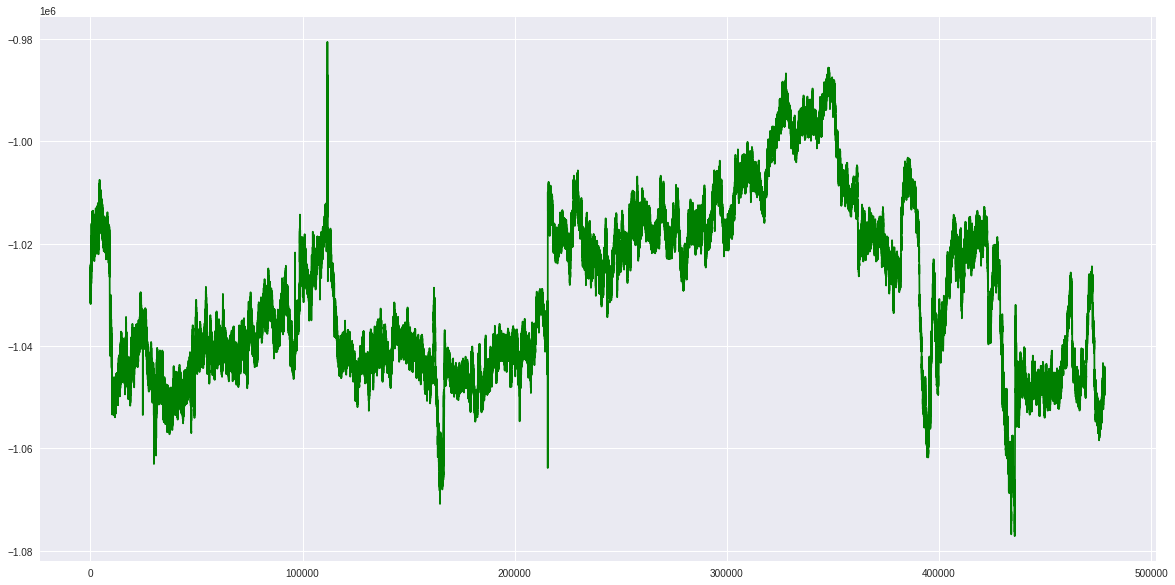

In [2]:
plt.style.use('seaborn')

ppg525 = ppg['580nm'][0:]
plt.figure(1, figsize=(20,10))
# colors for the line plot
colors = ['green', 'red', 'purple']

plt.plot(ppg525, "g-", label='PPG at 525nm')


####Check Outliner

In [3]:
low = .0005
high = .9995
quant_df = ppg525.quantile([low, high])
print(quant_df)

0.0005   -1071890.0
0.9995    -987288.0
Name: 580nm, dtype: float64


###Remove Outliner

In [4]:
index = (ppg525.values < quant_df[high])
fal_idx = ~ index
ppg525[fal_idx] = np.nan

In [5]:
#interpolation
ppg525.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

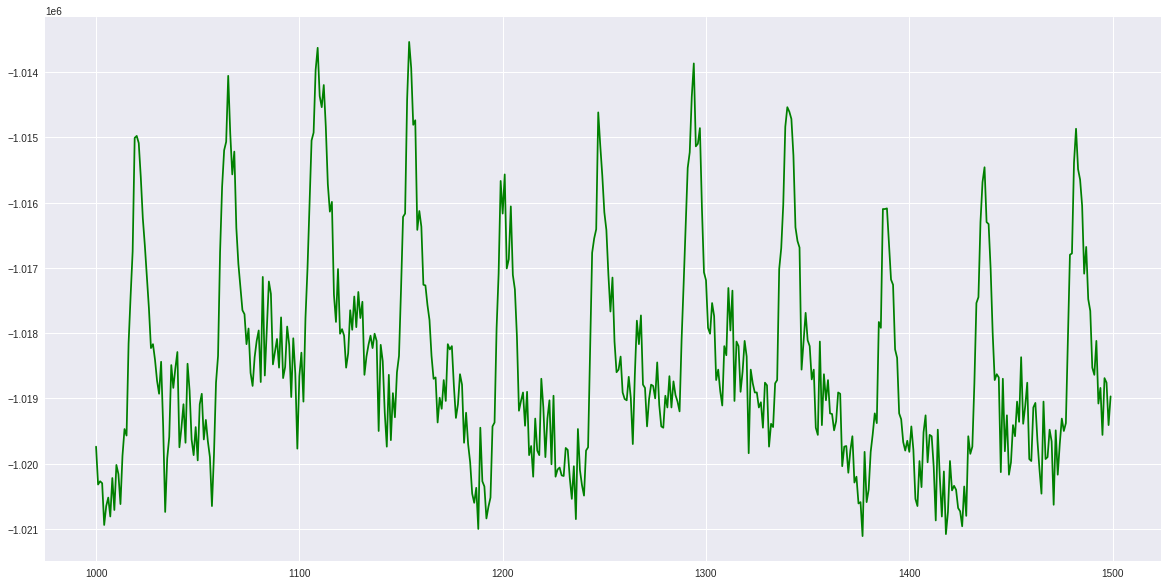

In [6]:
plt.figure(1, figsize=(20,10))
plt.plot(ppg525[1000:1500], "g-", label='PPG at 525nm')

###Filtering with S-Golay filter

In [123]:
from scipy.signal import savgol_filter
filter_PPG = savgol_filter(ppg525, 25, 7, mode='nearest')

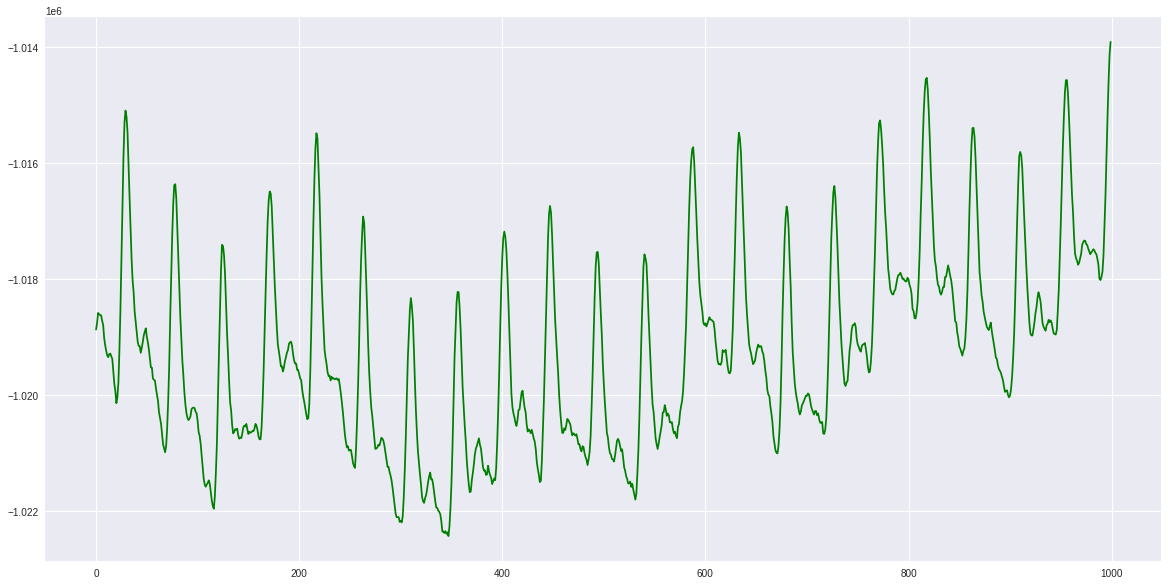

In [124]:
plt.figure(1, figsize=(20,10))
plt.plot(filter_PPG[1500:2500], "g-", label='PPG at 525nm')

# Detect peak

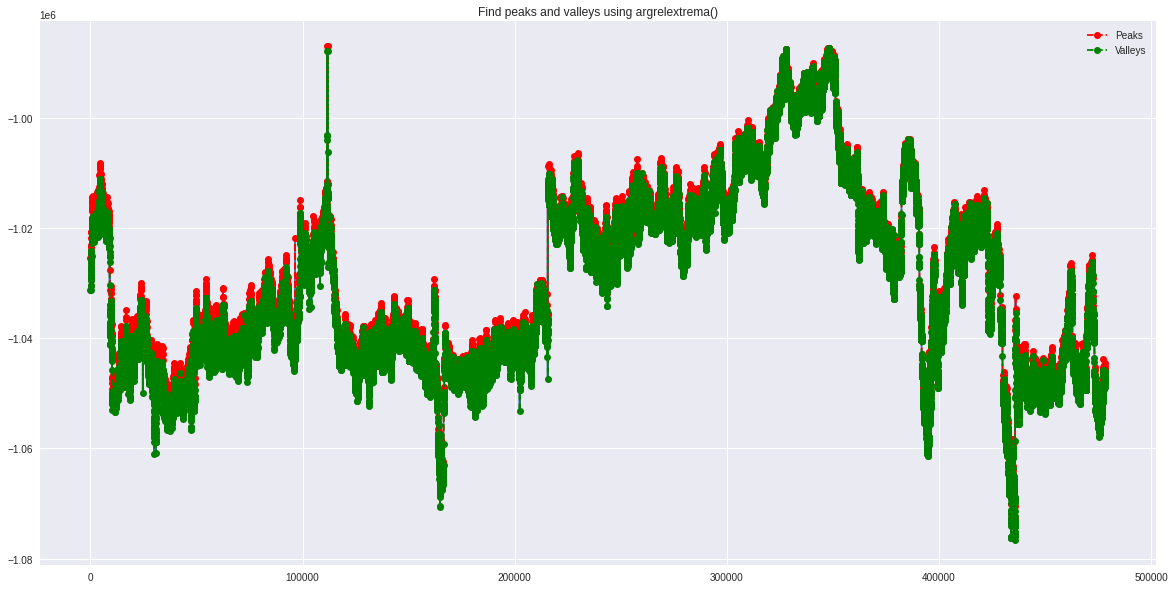

In [9]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

L1, L2 = 0, len(filter_PPG)
# find peak max
peak_idxs = signal.argrelextrema(filter_PPG, np.greater,order=18)
peak_idxs = peak_idxs[0]
peak_idxs = [i  for i in peak_idxs if (i >=L1 and i <=L2)]

#find peak min
valley_idxs = signal.argrelextrema(filter_PPG, np.less,order=1)
valley_idxs = valley_idxs[0]
valley_idxs = [i  for i in valley_idxs if (i >=L1 and i <=L2)]
#plot main graph
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(filter_PPG[L1:L2])
# plot peaks
peak_x = [i - L1 for i in peak_idxs]
peak_y =  filter_PPG[peak_idxs]
ax.plot(peak_x, peak_y, marker='o', linestyle='dashed', color='r', label='Peaks')
# plot valleys
valley_x = [i - L1 for i in valley_idxs]
valley_y =  filter_PPG[valley_idxs]
ax.plot(valley_x, valley_y, marker='o', linestyle='dashed', color='g', label='Valleys')

# Save graph to file.
plt.title('Find peaks and valleys using argrelextrema()')
plt.legend(loc='best')
#plt.savefig('argrelextrema.png')

In [158]:
len(peak_y), len(valley_y)

(9937, 57780)

### Reselecting valleys


In [10]:
def select_valley(peaks,valleys):
  assert len(peaks) < len(valleys), "Need the valley set bigger than the peak set."
  assert len(valleys) > 2, "Need the valley set at least 2 element."
  assert len(peaks) > 1, "Need the valley set at least 1 element."
  val = []
  for p in peaks:
    for v,v_next in zip(valleys[0:-1], valleys[1:]):
      if v < p and v_next > p:
        val.append(v)
      #elif ((v < p) and ((v - val[-1])> np.mean(np.diff(val)*0.9))):
      #  val.append(v)
  #if (valleys[-1] - val[-1])>np.mean(np.diff(val))*0.8:
  #  val.append(valleys[-1])
  return val

## Select vally close to peak set
val = select_valley(peak_idxs,valley_idxs)

In [11]:
len(val), len(peak_idxs), len(valley_idxs)

(9936, 9937, 57780)

#### Draw in region (L1, L2)

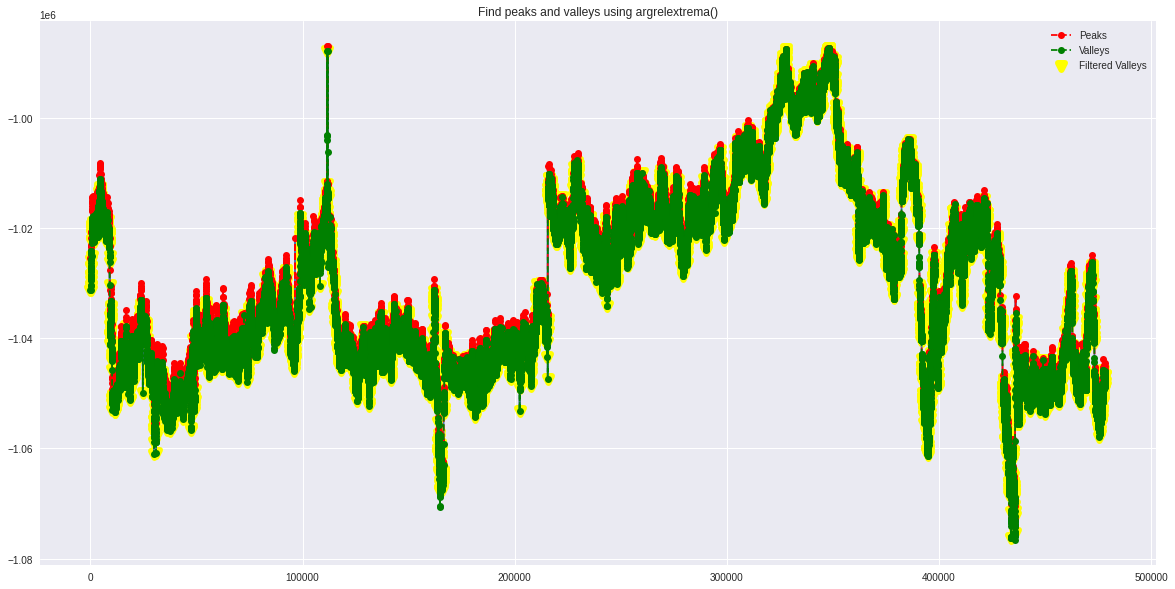

In [18]:
L1, L2 = 0, len(filter_PPG)
#plot main graph
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(filter_PPG[L1:L2])
# plot peaks
peak_x = [i - L1 for i in peak_idxs if i>=L1 and i < L2]
peak_y =  filter_PPG[np.array(peak_x)+L1]
ax.plot(peak_x, peak_y, marker='o', linestyle='dashed', color='r', label='Peaks')
# plot valleys
valley_x = [i - L1 for i in valley_idxs if i>=L1 and i < L2]
valley_y =  filter_PPG[np.array(valley_x)+L1 ]
ax.plot(valley_x, valley_y, marker='o', linestyle='dashed', color='g', label='Valleys')
# plot filterd valleys
valley_filtx = [i - L1 for i in val if i>=L1 and i < L2]
valley_filty =  filter_PPG[np.array(valley_filtx)+L1]
ax.scatter(valley_filtx, valley_filty, marker='v', linewidth=6, color='yellow', label='Filtered Valleys')
# Save graph to file.
plt.title('Find peaks and valleys using argrelextrema()')
plt.legend(loc='best')
#plt.savefig('argrelextrema.png')

### Draw difference Peak-Valley

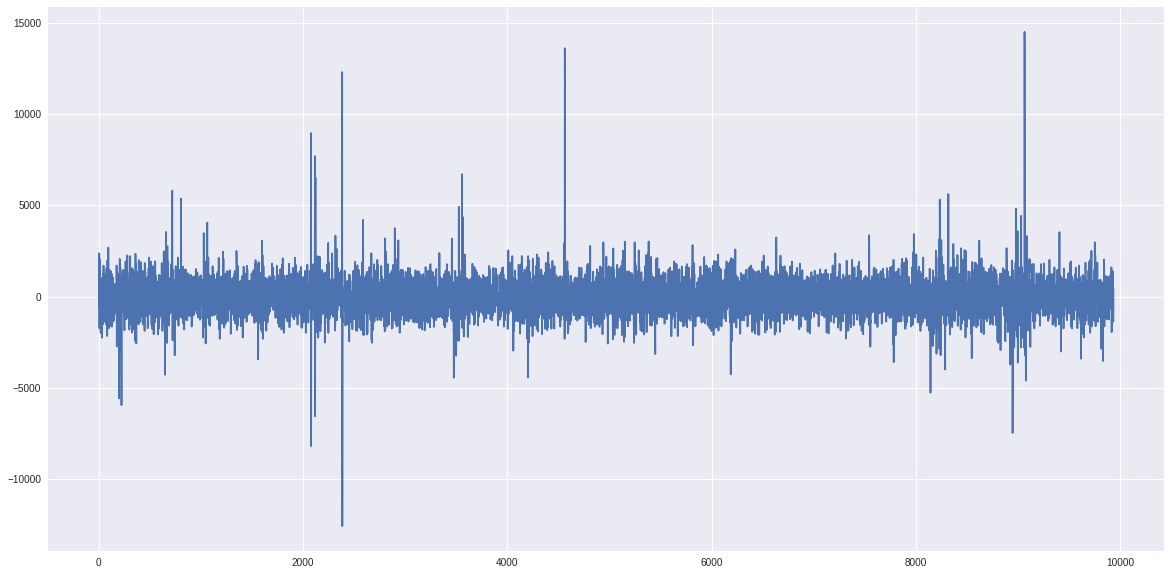

In [26]:
L = min(len(peak_y), len(valley_y))

z = np.array(peak_y[0:L-1]) - np.array(valley_y[1:L])

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(z[0:10000])




In [83]:
dz = np.gradient(z)
df_z = pd.DataFrame(dz)
df_z.describe()

,0
count,9936.000000
mean,-2.686274
std,1038.150932
min,-12600.935299
25%,-626.157421
50%,-19.858154
75%,605.129768
max,14525.669332


<Figure size 720x720 with 0 Axes>

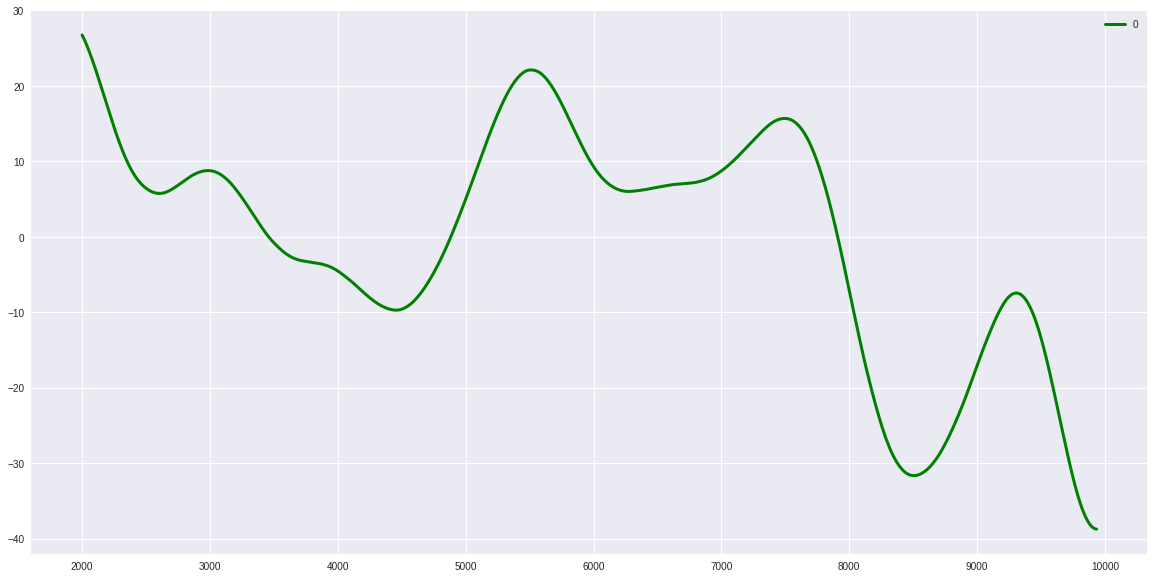

In [92]:
plt.figure(1, figsize=(10,10))
# colors for the line plot
#colors = ['green', 'red', 'purple']

dzMA = df_z.rolling(2000, win_type='blackman' ).mean()### 'blackman','bohman'win_type='None'
### create a combine dataframe
#df = pd.DataFrame(dzMA)
#df['avg'] = ppgMVA
#plt.plot(ppg525, "g-", label='PPG at 525nm')
#plt.plot(ppgMVA, "r-", label='Moving Average of PPG at 525nm')
dzMA.plot(color=colors, linewidth=3, figsize=(20,10))

# modify ticks size
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.legend(labels =['PPG at 525nm', 'Moving Average PPG' ], fontsize=14)

# title and labels
#plt.title('PPGs at Guan point in 2 hours', fontsize=20)
#plt.xlabel('Sample', fontsize=16)
#plt.ylabel('Amplitude', fontsize=16)

In [212]:
len(z), L

(9937, 9937)

### Extract PPG from Baseline

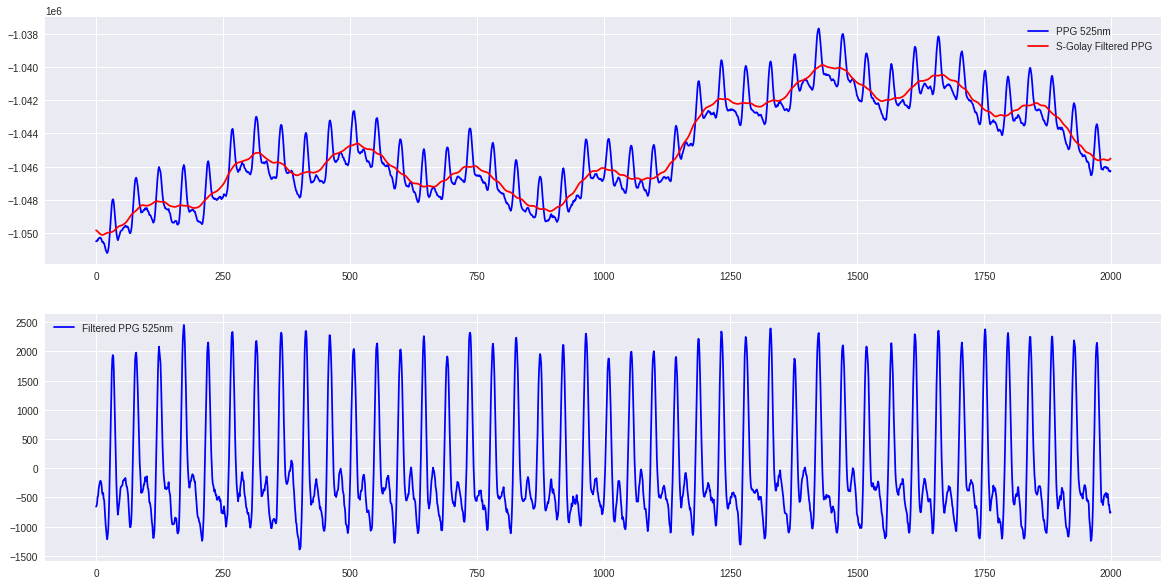

In [100]:
from scipy.signal import savgol_filter

filter_PPG1 = savgol_filter(filter_PPG, window_length = 211, polyorder =5)

bwrPPG1 = filter_PPG - filter_PPG1

plt.subplots(2, 1, figsize=(20,10))
L1, L2 = 13000, 15000
#plt.subplot(3, 1, 1)
plt.subplot(2, 1, 1)
plt.plot(filter_PPG[L1:L2], "b-", label="PPG 525nm")
plt.plot(filter_PPG1[L1:L2], "r-", label="S-Golay Filtered PPG")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(bwrPPG1[L1:L2], "b-", label="Filtered PPG 525nm")
plt.legend()

### Detect peaks filter signal

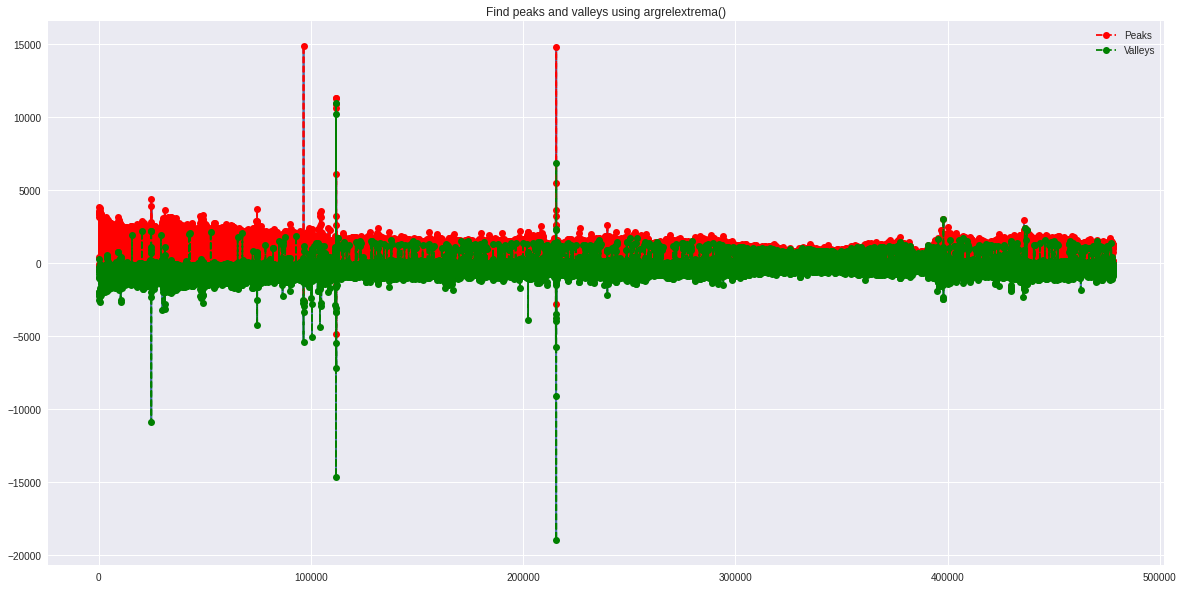

In [145]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

#L1, L2 = 4500,5500#len(bwrPPG1)
L1, L2 = 0,len(bwrPPG1)
#L1, L2 = 24000,25000#len(bwrPPG1)
# find peak max
peak_idxs1 = signal.argrelextrema(bwrPPG1, np.greater,order=5)
peak_idxs1 = peak_idxs1[0]
peak_idxs1 = [i  for i in peak_idxs1 if (i >=L1 and i <=L2)]

#find peak min
valley_idxs1 = signal.argrelextrema(bwrPPG1, np.less,order=1)
valley_idxs1 = valley_idxs1[0]
valley_idxs1 = [i  for i in valley_idxs1 if (i >=L1 and i <=L2)]
#plot main graph
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(bwrPPG1[L1:L2])
# plot peaks
peak_x1 = [i - L1 for i in peak_idxs1]
peak_y1 =  bwrPPG1[peak_idxs1]
ax.plot(peak_x1, peak_y1, marker='o', linestyle='dashed', color='r', label='Peaks')
# plot valleys
valley_x1 = [i - L1 for i in valley_idxs1]
valley_y1 =  bwrPPG1[valley_idxs1]
ax.plot(valley_x1, valley_y1, marker='o', linestyle='dashed', color='g', label='Valleys')

# Save graph to file.
plt.title('Find peaks and valleys using argrelextrema()')
plt.legend(loc='best')
#plt.savefig('argrelextrema.png')

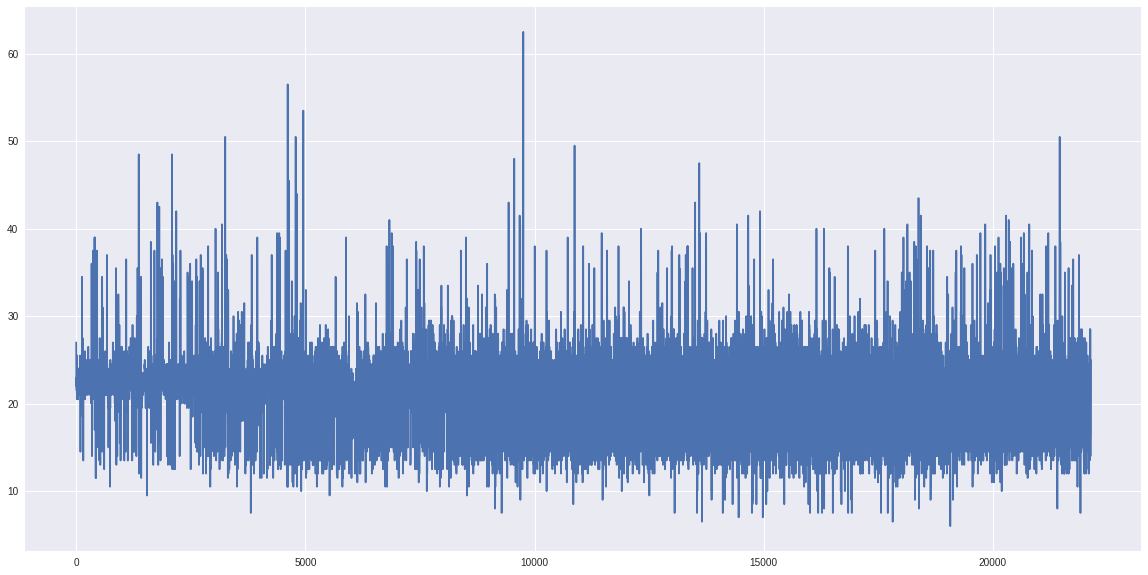

In [150]:
R_PTT = pd.DataFrame(np.gradient(peak_idxs1))
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(R_PTT)

<Figure size 720x720 with 0 Axes>

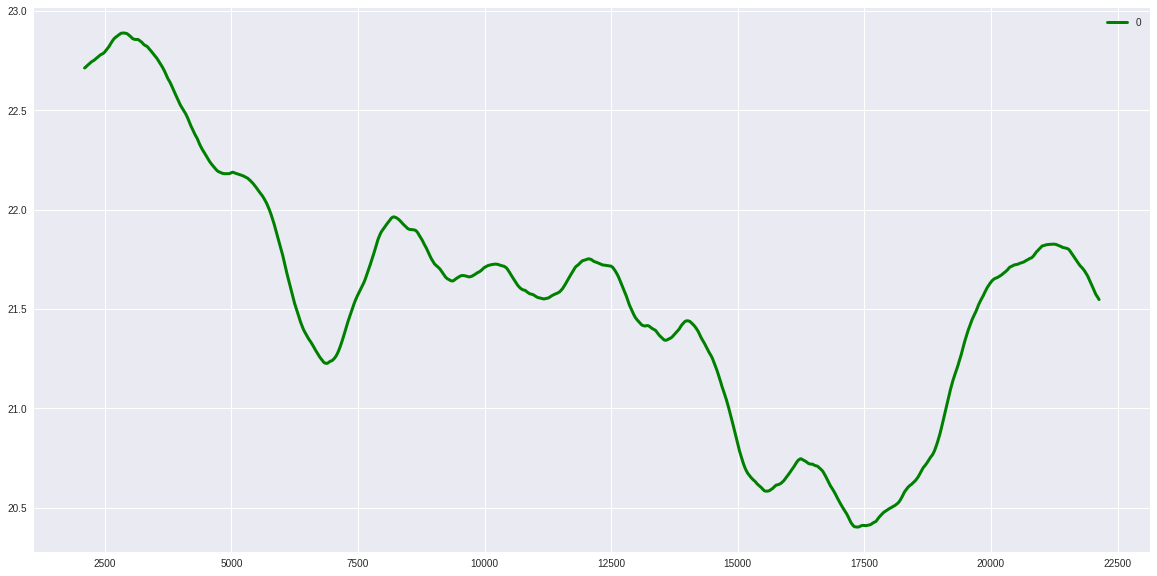

In [172]:
plt.figure(1, figsize=(10,10))
# colors for the line plot
#colors = ['green', 'red', 'purple']

#dzMA = R_PTT.rolling(2000, win_type='blackman' ).mean()### 'blackman','bohman'win_type='None'
dzMA = R_PTT.rolling(2100, win_type='triang' ).mean()### 'blackman','bohman'win_type='None'
### create a combine dataframe
#df = pd.DataFrame(dzMA)
#df['avg'] = ppgMVA
#plt.plot(ppg525, "g-", label='PPG at 525nm')
#plt.plot(ppgMVA, "r-", label='Moving Average of PPG at 525nm')
dzMA.plot(color=colors, linewidth=3, figsize=(20,10))

In [151]:
R_PTT.describe()

,0
count,22137.000000
mean,21.601075
std,4.478102
min,6.000000
25%,18.000000
50%,23.000000
75%,24.500000
max,62.500000


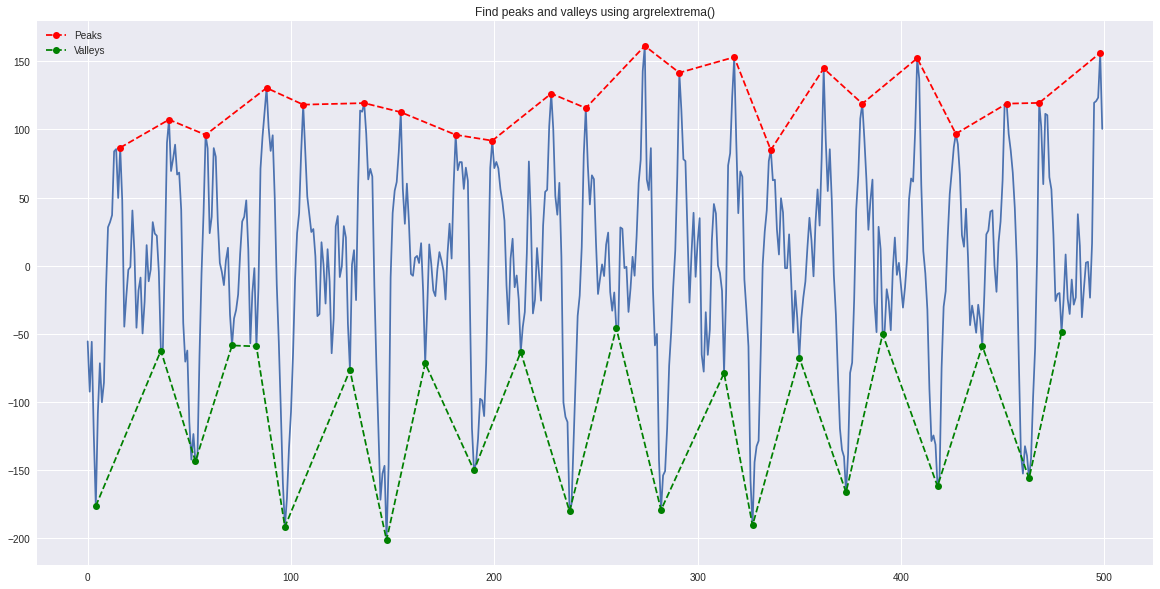

In [115]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

L1, L2 = 7000, 7500#len(bwrPPG1)
# find peak max
d2_bwrPPG1 = np.gradient(np.gradient(bwrPPG1))
peak_idxs1 = signal.argrelextrema(d2_bwrPPG1, np.greater,order=10)
peak_idxs1 = peak_idxs1[0]
peak_idxs1 = [i  for i in peak_idxs1 if (i >=L1 and i <=L2)]

#find peak min
valley_idxs1 = signal.argrelextrema(d2_bwrPPG1, np.less,order=10)
valley_idxs1 = valley_idxs1[0]
valley_idxs1 = [i  for i in valley_idxs1 if (i >=L1 and i <=L2)]
#plot main graph
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(d2_bwrPPG1[L1:L2])
# plot peaks
peak_x1 = [i - L1 for i in peak_idxs1]
peak_y1 =  d2_bwrPPG1[peak_idxs1]
ax.plot(peak_x1, peak_y1, marker='o', linestyle='dashed', color='r', label='Peaks')
# plot valleys
valley_x1 = [i - L1 for i in valley_idxs1]
valley_y1 =  d2_bwrPPG1[valley_idxs1]
ax.plot(valley_x1, valley_y1, marker='o', linestyle='dashed', color='g', label='Valleys')

# Save graph to file.
plt.title('Find peaks and valleys using argrelextrema()')
plt.legend(loc='best')
#plt.savefig('argrelextrema.png')

###Reading Glucose

In [67]:
from pandas import read_csv
file_path = file_path = 'drive/My Drive/Dataset/GlucoseLong02_02April.csv'
#file_path = file_path = 'drive/My Drive/Dataset/GlucoseLong02_12Mar.csv'
dataset = read_csv(file_path,
                   
                   parse_dates=['Timestamp (YYYY-MM-DDThh:mm:ss)'],
                   index_col=['Timestamp (YYYY-MM-DDThh:mm:ss)'],
                   skiprows= [i for i in range(1,11)],
                   na_values= ['nan'])

 ### Find index in time series

In [68]:
import numpy
def find_index(dataset, time):
   s = [index for index in range(len(dataset.index.values)) if dataset.index.values[index] == numpy.datetime64(time)]
   return s[0]

In [72]:
x_start = find_index(dataset, '2021-04-02T15:14:40')  #2021-04-02T15:09:40  2021-04-01T13:59:40 2021-04-01T13:19:41 2021-03-25T17:44:37
x_stop = find_index(dataset, '2021-04-02T17:19:40') #2021-04-02T17:19:40   2021-04-01T16:44:41 2021-04-02T18:49:42

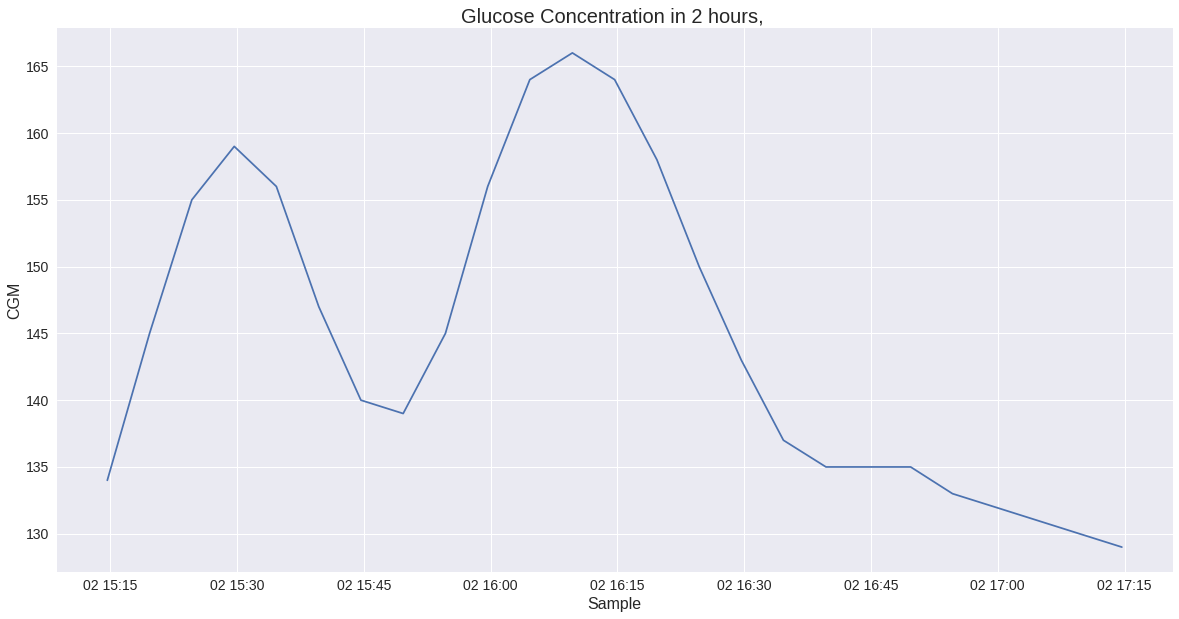

In [73]:
df_glu = dataset['Glucose Value (mg/dL)'][x_start:x_stop]
plt.figure(1, figsize=(20,10))
plt.plot(df_glu)
# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# title and labels
plt.title('Glucose Concentration in 2 hours, ', fontsize=20)
plt.xlabel('Sample', fontsize=16)
plt.ylabel('CGM', fontsize=16)
plt.show()